In [26]:
from tabpfn.scripts.transformer_prediction_interface import TabPFNClassifier
import numpy as np
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, QuantileTransformer, PowerTransformer, RobustScaler
import torch
from torch.nn import MultiheadAttention
from torch import optim
import torch.nn as nn

device = "cuda:2"

model = TabPFNClassifier(device=device)
module = model.model[2]

Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cuda:2 device
Batch size: 1
Using distributed training: False
Using a Transformer with 25.82 M parameters


In [18]:
from tabpfn.utils import normalize_data, to_ranking_low_mem, remove_outliers
from tabpfn.priors.utils import normalize_by_used_features_f

normalize_with_test = True #TODO change
#eval_position = 100
normalize_to_ranking = False
max_features=100
normalize_with_sqrt = False

def preprocess_input(eval_xs, eval_ys, categorical_feats, preprocess_transform):
    import warnings

    if eval_xs.shape[1] > 1:
        raise Exception("Transforms only allow one batch dim - TODO")
    if preprocess_transform != 'none':
        if preprocess_transform == 'power' or preprocess_transform == 'power_all':
            pt = PowerTransformer(standardize=True)
        elif preprocess_transform == 'quantile' or preprocess_transform == 'quantile_all':
            pt = QuantileTransformer(output_distribution='normal')
        elif preprocess_transform == 'robust' or preprocess_transform == 'robust_all':
            pt = RobustScaler(unit_variance=True)

    # eval_xs, eval_ys = normalize_data(eval_xs), normalize_data(eval_ys)
    eval_xs = normalize_data(eval_xs, normalize_positions=-1 if normalize_with_test else eval_position)

    # Removing empty features
    eval_xs = eval_xs[:, 0, :]
    sel = [len(torch.unique(eval_xs[0:eval_ys.shape[0], col])) > 1 for col in range(eval_xs.shape[1])]
    eval_xs = eval_xs[:, sel]

    warnings.simplefilter('error')
    if preprocess_transform != 'none':
        eval_xs = eval_xs.cpu().numpy()
        feats = set(range(eval_xs.shape[1])) if 'all' in preprocess_transform else set(
            range(eval_xs.shape[1])) - set(categorical_feats)
        for col in feats:
            try:
                pt.fit(eval_xs[0:eval_position, col:col + 1])
                trans = pt.transform(eval_xs[:, col:col + 1])
                # print(scipy.stats.spearmanr(trans[~np.isnan(eval_xs[:, col:col+1])], eval_xs[:, col:col+1][~np.isnan(eval_xs[:, col:col+1])]))
                eval_xs[:, col:col + 1] = trans
            except:
                pass
        eval_xs = torch.tensor(eval_xs).float()
    warnings.simplefilter('default')

    eval_xs = eval_xs.unsqueeze(1)

    # TODO: Cautian there is information leakage when to_ranking is used, we should not use it
    eval_xs = remove_outliers(eval_xs, normalize_positions=-1 if normalize_with_test else eval_position) if not normalize_to_ranking else normalize_data(to_ranking_low_mem(eval_xs))
    # Rescale X
    eval_xs = normalize_by_used_features_f(eval_xs, eval_xs.shape[-1], max_features,
                                            normalize_with_sqrt=normalize_with_sqrt)

    return eval_xs.detach().to(device)


In [27]:
def compute_accuracy_rf(X, y, n_train):
    # Move X and y to CPU
    X = X.to("cpu")
    y = y.to("cpu")
    # check if regression or classification
    if len(np.unique(y)) > len(y) / 3:
        rf = RandomForestRegressor()
        classif = False
        print("Regression")
    else:
        rf = RandomForestClassifier()
        classif = True
        print("Classification")
    X_train, X_test = X[:n_train], X[n_train:]
    y_train, y_test = y[:n_train], y[n_train:]
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    if classif:
        return accuracy_score(y_test, y_pred)
    else:
        return r2_score(y_test, y_pred)

def compute_accuracy_tabpfn_original(X, y, n_train):
    X = X.to("cpu") #FIXME
    y = y.to("cpu")
    X_train, X_test = X[:n_train], X[n_train:]
    y_train, y_test = y[:n_train], y[n_train:]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

def compute_accuracy_tabpfn(X, y, n_train, preprocess=False):
    # reshape X to be 3D
    X = X.reshape(X.shape[0], 1, X.shape[1])
    # reshape y to be 2D
    y = y.reshape(y.shape[0], 1)
    if preprocess:
        X = preprocess_input(X, y, [], 'power')
    X = X.to(device)
    y_pred = torch.argmax(module((X, y), single_eval_pos=n_train, x_already_encoded=False), dim=-1).reshape(-1)
    # Check the accuracy
    print(accuracy_score(y[-len(y_pred):].cpu(), y_pred.cpu())) #FIXME
    

In [7]:
def train_attention(module, X1, X2, y, n_train, preprocess=False, lr=0.01, n_epochs=100, train_tabpfn=False):
    # reshape X to be 3D
    X1 = X1.reshape(X1.shape[0], 1, X1.shape[1])
    X2 = X2.reshape(X2.shape[0], 1, X2.shape[1])
    # reshape y to be 2D
    y = y.reshape(y.shape[0], 1)
    if preprocess:
        X1 = preprocess_input(X1, y, [], 'power')
        X2 = preprocess_input(X2, y, [], 'power')

    n = 512 # to be compatible with pretrained TabPFN
    attention = MultiheadAttention(embed_dim=n, num_heads=1, dropout=0.0, device=device)
    W_q = nn.Linear(n, n).to(device)
    W_k = nn.Linear(n, n).to(device)
    W_v = nn.Linear(n, n).to(device)
    #W_o = nn.Linear(n, 2).to(device)
    W_q.requires_grad = True
    W_k.requires_grad = True
    W_v.requires_grad = True
    #W_o.requires_grad = True
    train_size = n_train
    #TODO think about this. Do I really need a train set?
    val_size = (len(X1) - train_size) // 2
    test_size = len(X1) - train_size - val_size
    if train_tabpfn:
        optimizer = optim.Adam([*W_q.parameters(), *W_k.parameters(), *W_v.parameters(), *module.parameters()], lr=lr)
    else:
        optimizer = optim.Adam([*W_q.parameters(), *W_k.parameters(), *W_v.parameters()], lr=lr)
        with torch.no_grad():
            input = module.encoder(X1)
            input2 = module.encoder(X2)
    for i in range(n_epochs):
        optimizer.zero_grad()
        if train_tabpfn:
            input = module.encoder(X1)
            input2 = module.encoder(X2)
        Q = W_q(input)
        K = W_k(input2)
        V = W_v(input2)
        #full_input = input + attention(Q, K, V)[0]
        full_input = input + attention(Q, K, V)[0]
        y_pred = module((full_input, y), single_eval_pos=train_size, x_already_encoded=True).squeeze()
        #y_pred = W_o(full_input).squeeze()
        loss = torch.nn.functional.cross_entropy(y_pred[:val_size], y[-len(y_pred):-len(y_pred) + val_size].squeeze().long())
        loss.backward()
        optimizer.step()
        if i % 2 == 0:
            print(loss)
        if i % 10 == 0:
            y_pred = torch.argmax(y_pred, dim=-1).reshape(-1)
            print("Test accuracy:")
            print("Number of test samples: ", test_size)
            print(accuracy_score(y[-len(y_pred) + val_size:].cpu(), y_pred[val_size:].cpu()))
            print("Train accuracy:")
            #print("Number of train samples: ", train_size)
            #print(accuracy_score(y[:train_size].cpu(), y_pred[:train_size].cpu()))
            print("Val accuracy:")
            print("Number of val samples: ", val_size)
            print(accuracy_score(y[-len(y_pred):-len(y_pred) + val_size].cpu(), y_pred[:val_size].cpu()))

    
    

In [8]:

import torch
import torch.nn as nn
import torch.nn.functional as F

# class PairwiseTransformer(nn.Module):
#     def __init__(self, n_features, n_features_2, nhead, dim_feedforward):
#         super(PairwiseTransformer, self).__init__()
#         self.transformer = nn.Transformer(
#             d_model=n_features + n_features_2,
#             nhead=nhead,
#             num_encoder_layers=1,
#             num_decoder_layers=1,
#             dim_feedforward=dim_feedforward,
#         )
#         self.fc = nn.Linear(n_features + n_features_2, 1)

#     def forward(self, x1, x2):
#         print(x1.shape)
#         print(x2.shape)
#         combined_input = torch.cat((x1, x2), dim=-1).unsqueeze(0)
#         print(combined_input.shape)
#         output = self.transformer(combined_input, combined_input)
#         output = output.squeeze(0)
#         score = self.fc(output)
#         return score.squeeze(-1)

import torch
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, classif=True):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.classif = classif
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        if self.classif:
            out = F.softmax(out, dim=-1)
        return out

class PairwiseMLP(nn.Module):
    def __init__(self, n_features, n_features_2, dim_feedforward):
        super(PairwiseMLP, self).__init__()
        self.fc1 = nn.Linear(n_features + n_features_2, dim_feedforward)
        self.fc2 = nn.Linear(dim_feedforward, dim_feedforward)
        self.fc3 = nn.Linear(dim_feedforward, 1)

    def forward(self, x1, x2):
        combined_input = torch.cat((x1, x2), dim=-1)
        output = F.relu(self.fc1(combined_input))
        output = F.relu(self.fc2(output))
        score = self.fc3(output)
        return score.squeeze(-1)
    

class CustomModel(nn.Module):
    def __init__(self, n_features, n_features_2, dim_feedforward):
        super(CustomModel, self).__init__()
        self.scorer = PairwiseMLP(n_features, n_features_2, dim_feedforward)

    def forward(self, M1, M2):
        scores = []
        for i in range(M1.size(0)):
                score = self.scorer(M1[i].repeat(M2.shape[0], 1), M2)
                scores.append(score)
        scores = torch.stack(scores).view(M1.size(0), M2.size(0))
        # Normalize scores
        scores = F.softmax(scores, dim=1)
        M2_avg = scores @ M2
        return torch.cat((M1, M2_avg), dim=1)

# Example usage
n_samples_batch, n_features = 32, 128
n_samples_2, n_features_2 = 16, 64
nhead = 8
dim_feedforward = 256

matching_model = CustomModel(n_features, n_features_2, dim_feedforward)

M1 = torch.randn(n_samples_batch, n_features)
M2 = torch.randn(n_samples_2, n_features_2)

output = matching_model(M1, M2)
print(output.shape)  # Expected output shape: (n_samples_batch, n_features + n_features_2)

    


torch.Size([32, 192])


In [6]:
# Try to train a PairwiseMLP to return X1[0] - X2[0]
n_features = 10

pairwise_model = PairwiseMLP(n_features, n_features, 256)
optimizer = torch.optim.Adam(pairwise_model.parameters(), lr=0.0001)
for i in range(5000):
    X1 = torch.randn(1024, n_features)
    X2 = torch.randn(1024, n_features)
    # y = exponential decay of X1[0] - X2[0]
    y = torch.exp(- (X1[:, 0] - X2[:, 0])**2)
    optimizer.zero_grad()
    y_pred = pairwise_model(X1, X2)
    loss = torch.nn.functional.mse_loss(y_pred, y)
    loss.backward()
    optimizer.step()
    if i % 10 == 0:
        print("Loss", loss)
        print("abs", (y_pred - y).abs().mean())
        X1_test = torch.randn(256, n_features)
        X2_test = torch.randn(256, n_features)
        y_test =torch.exp(- (X1_test[:, 0] - X2_test[:, 0])**2)
        y_pred_test = pairwise_model(X1_test, X2_test)
        print("--------")
        print("Test loss", torch.nn.functional.mse_loss(y_pred_test, y_test))
        print("Test abs", (y_pred_test - y_test).abs().mean())
        print("--------")



Loss tensor(0.3938, grad_fn=<MseLossBackward>)
abs tensor(0.5040, grad_fn=<MeanBackward0>)
--------
Test loss tensor(0.3403, grad_fn=<MseLossBackward>)
Test abs tensor(0.4515, grad_fn=<MeanBackward0>)
--------
Loss tensor(0.1962, grad_fn=<MseLossBackward>)
abs tensor(0.3621, grad_fn=<MeanBackward0>)
--------
Test loss tensor(0.1768, grad_fn=<MseLossBackward>)
Test abs tensor(0.3493, grad_fn=<MeanBackward0>)
--------
Loss tensor(0.1566, grad_fn=<MseLossBackward>)
abs tensor(0.3507, grad_fn=<MeanBackward0>)
--------
Test loss tensor(0.1624, grad_fn=<MseLossBackward>)
Test abs tensor(0.3629, grad_fn=<MeanBackward0>)
--------
Loss tensor(0.1582, grad_fn=<MseLossBackward>)
abs tensor(0.3527, grad_fn=<MeanBackward0>)
--------
Test loss tensor(0.1529, grad_fn=<MseLossBackward>)
Test abs tensor(0.3417, grad_fn=<MeanBackward0>)
--------
Loss tensor(0.1486, grad_fn=<MseLossBackward>)
abs tensor(0.3448, grad_fn=<MeanBackward0>)
--------
Test loss tensor(0.1609, grad_fn=<MseLossBackward>)
Test abs

torch.Size([32])


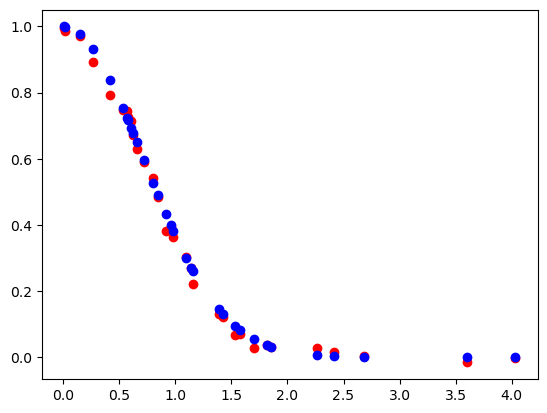

In [7]:
import matplotlib.pyplot as plt
import numpy as np
X1 = torch.randn(32, n_features)
X2 = torch.randn(32, n_features)
y = torch.exp(- (X1[:, 0] - X2[:, 0])**2)
y_pred = pairwise_model(X1, X2)
print(y_pred.shape)
plt.scatter(torch.abs(X1[:, 0] - X2[:, 0]).detach(), y_pred.detach(), c="red")
plt.scatter(torch.abs(X1[:, 0] - X2[:, 0]).detach(), y.detach(), c="blue")



In [9]:
def train_matching(X1, X2, y, batch_size, preprocess=False, lr=0.01, n_epochs=100, dim_feedforward=256, train_prop=0.7):
    # reshape X to be 3D
    X1 = X1.reshape(X1.shape[0], 1, X1.shape[1])
    X2 = X2.reshape(X2.shape[0], 1, X2.shape[1])
    # reshape y to be 2D
    y = y.reshape(y.shape[0], 1)
    if preprocess:
        X1 = preprocess_input(X1, y, [], 'power')
        X2 = preprocess_input(X2, y, [], 'power')
    # reshape X to be 2D
    X1 = X1.reshape(X1.shape[0], X1.shape[2])
    X2 = X2.reshape(X2.shape[0], X2.shape[2]).to(device)
    # reshape y to be 1D
    y = y.reshape(y.shape[0])
    scorer = CustomModel(n_features=X1.shape[1], n_features_2=X2.shape[1], dim_feedforward=dim_feedforward)
    n_classes = torch.unique(y).shape[0]
    print("num classes", n_classes)
    predictor = MLP(input_size=X1.shape[1] + X2.shape[1], hidden_size=dim_feedforward, output_size=n_classes, classif=True)
    # move to GPU
    scorer = scorer.to(device)
    predictor = predictor.to(device)
    optimizer = optim.Adam([*scorer.parameters(), *predictor.parameters()], lr=lr)
    # create a dataset
    print(X1.shape)
    print(y.shape)
    X1_train = X1[:int(train_prop * len(X1))]
    X1_test = X1[int(train_prop * len(X1)):]
    y_train = y[:int(train_prop * len(y))]
    y_test = y[int(train_prop * len(y)):]
    dataset_train = torch.utils.data.TensorDataset(X1_train, y_train)
    dataset_test = torch.utils.data.TensorDataset(X1_test, y_test)
    # create a data loader
    dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=True)
    loss_function = torch.nn.CrossEntropyLoss()
    for epoch in range(n_epochs):
        print("Epoch", epoch)
        print("----------------")
        train_loss = 0
        train_accuracy = 0
        for X1_batch, y_batch in dataloader_train:
            # move to GPU
            X1_batch = X1_batch.to(device)
            y_batch = y_batch.to(device)
            # get the predictions
            output = scorer(X1_batch, X2)
            output = predictor(output)
            # calculate the loss
            loss = loss_function(output, y_batch)
            train_loss += loss.item()
            accuracy = (output.argmax(dim=1) == y_batch).float().mean()
            train_accuracy += accuracy
            #print("Train loss", loss.item())
            # backprop
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        print("Train loss", train_loss / len(dataloader_train))
        print("Train accuracy", train_accuracy / len(dataloader_train))
        # calculate the accuracy
        print("---------------")
        test_loss = 0
        test_accuracy = 0
        for X1_batch, y_batch in dataloader_test:
            # move to GPU
            X1_batch = X1_batch.to(device)
            y_batch = y_batch.to(device)
            # Calculate the predictions
            output = scorer(X1_batch, X2)
            output = predictor(output)
            # calculate the loss and accuracy
            loss = loss_function(output, y_batch)
            test_loss += loss.item()
            # calculate the accuracy
            y_pred = output.argmax(dim=1)
            accuracy = (y_pred == y_batch).float().mean()
            test_accuracy += accuracy
        print("Test loss", test_loss / len(dataloader_test))
        print("Test accuracy", test_accuracy / len(dataloader_test))
        print("---------------")
    return scorer, predictor

            
    

# Toy example

In [8]:
# create a non linear function
#f = torch.functional.F.relu
#f = lambda x: x**2


In [89]:
# Create fake datasets
# Create a first dataset with columns A, B
#torch.manual_seed(20)
dataset1 = np.random.rand(10000, 10)
# bucketize the columns
dataset1_bucketized = np.floor(dataset1 * 10)
# assign a random value to each combination of bucketized values
unique_values = np.unique(dataset1_bucketized, axis=0)
# create a dictionary
dict_values = {}
for i in range(len(unique_values)):
    key = tuple(unique_values[i])
    dict_values[key] = torch.rand(1)

# create y from the dictionary
y = torch.zeros(dataset1.shape[0])
for i in range(dataset1.shape[0]):
    key = tuple(dataset1_bucketized[i])
    y[i] = dict_values[key]

# Create a second dataset with the unique values of the first dataset and y as the last column
dataset2 = np.zeros((11, dataset1.shape[1] + 1))
for i in range(10):
    dataset2[:, i] = np.arange(dataset1.shape[1] + 1)
dataset2[:, -1] = np.random.randin








#dataset2.requires_grad = True
#dataset1.requires_grad = True

# Make it a classification problem
#y = (y > np.median(y)).float()

#print(np.unique(y, return_counts=True))

# Move to GPU
#dataset1 = dataset1.to(device)
#dataset2 = dataset2.to(device)
#y = y.to(device)
# Shuffle dataset2
#dataset2 = dataset2[torch.randperm(len(dataset2))]

In [38]:
X1 = torch.randn(500, 10)
X2 = torch.randn(3000, 10)

# Create a random function with an MLP
f = MLP(input_size=10, hidden_size=100, output_size=1, classif=False)
y = f(X1)



In [11]:
# scores = []
# pairwise_model = pairwise_model.to(device)
# for i in range(dataset1.size(0)):
#         for j in range(dataset2.size(0)):
#             #score = pairwise_model(dataset1[i], dataset2[j])
#             score = torch.exp(- (dataset1[i][0] -  dataset2[j][0])**2)
#             scores.append(score)
#         #score = pairwise_model(dataset1[i].repeat(dataset2.shape[0], 1), dataset2)
#         #scores.append(score)
# scores = torch.stack(scores).view(dataset1.size(0), dataset2.size(0))
# print(scores.shape)
# # find best match for each row
# best_match = torch.argmax(scores, dim=1)
# #best_matches = torch.argsort(scores, dim=1, descending=True)[:,:5]
# print(best_match.shape)
# # y_pred is the dim 1 of the best match
# y_pred = dataset2[best_match, 1]
# #y_pred = torch.mean(dataset2[best_matches, 1], dim=1)

# # rmse
# print(np.sqrt(np.mean((y_pred.cpu().numpy() - y.cpu().numpy())**2)))

# plt.scatter(y_pred.cpu(), y.cpu())


In [22]:
X1

tensor([[-0.8780, -1.2207, -0.6406,  ..., -1.0992, -0.1290,  0.3034],
        [-0.1706,  0.7942,  0.1720,  ..., -0.1920, -2.4479, -0.9503],
        [-0.1181,  0.9089, -2.1577,  ..., -0.1876, -0.5218,  0.4820],
        ...,
        [ 0.3391, -0.7876, -1.4242,  ...,  1.8168, -0.3592, -0.1758],
        [ 1.6243, -0.5512,  1.2396,  ..., -2.4787, -0.2446,  1.5140],
        [ 0.0963,  1.0195,  0.2070,  ...,  0.2282,  0.0640,  1.1154]])

In [41]:
print("-- Random Forest --")
y = f(X2)
print("Accuracy with dataset1", compute_accuracy_rf(X2.detach(), y.detach(), 300))
#print("Accuracy with dataset2", compute_accuracy_rf(dataset2, y, 1000))
#print("Accuracy with dataset1 + dataset2", compute_accuracy_rf(torch.cat((dataset1, dataset2), dim=1), y, 1000))

-- Random Forest --
Regression


/tmp/ipykernel_2180/3987199982.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


Accuracy with dataset1 0.5973345060904891


In [ ]:
# match indices of dataset1 and dataset2 on the first coordinate
distance = torch.cdist(dataset1[:, 0].reshape(-1, 1), dataset2[:, 0].reshape(-1, 1))
# replace the 2nd coordinate of dataset1 by the 2nd coordinate of dataset2
dataset1_copy = dataset1.clone()
dataset1_copy[:, 1] = torch.sum(dataset2[distance.argmin(dim=1)], dim=1)


print("-- Random Forest --")
print("Accuracy with dataset1", compute_accuracy_rf(dataset1_copy, y, 1000))
print("Accuracy with dataset2", compute_accuracy_rf(dataset2, y, 1000))


-- Random Forest --
Accuracy with dataset1 0.5033684210526316
Accuracy with dataset2 0.4947894736842105


In [21]:
print("-- TabPFN original --")
print("Accuracy with dataset1", compute_accuracy_tabpfn_original(dataset1, y, 1000))
#print("Accuracy with dataset2", compute_accuracy_tabpfn_original(dataset2, y, 1000))

-- TabPFN original --
interface
torch.Size([10000, 1, 10])
torch.Size([10000, 1])
1000
Accuracy with dataset1 0.9217777777777778


In [79]:
print("-- TabPFN --")
print("Without preprocessing")
print("Accuracy with dataset1", compute_accuracy_tabpfn(dataset1, y, 1000, preprocess=False))
print("Accuracy with dataset2", compute_accuracy_tabpfn(dataset2, y, 1000, preprocess=False))
print("With preprocessing")
print("Accuracy with dataset1", compute_accuracy_tabpfn(dataset1, y, 1000, preprocess=True))
print("Accuracy with dataset2", compute_accuracy_tabpfn(dataset2, y, 1000, preprocess=True))

-- TabPFN --
Without preprocessing
 ** On entry to SGEMM  parameter number 10 had an illegal value


RuntimeError: CUDA error: CUBLAS_STATUS_INVALID_VALUE when calling `cublasSgemm( handle, opa, opb, m, n, k, &alpha, a, lda, b, ldb, &beta, c, ldc)`

In [10]:
#train_attention(module, dataset1, dataset2, y, 1000, preprocess=True, lr=0.001, n_epochs=1000, train_tabpfn=False)
train_matching(dataset1, dataset2, y, 256, preprocess=True, lr=0.001, n_epochs=10)

num classes 10
torch.Size([10000, 10])
torch.Size([10000])
Epoch 0
----------------
Train loss 2.2130115372794017
Train accuracy tensor(0.2254, device='cuda:2')
---------------
Test loss 2.1438475449879966
Test accuracy tensor(0.3096, device='cuda:2')
---------------
Epoch 1
----------------
Train loss 2.08979537657329
Train accuracy tensor(0.3722, device='cuda:2')
---------------
Test loss 2.05389674504598
Test accuracy tensor(0.4228, device='cuda:2')
---------------
Epoch 2
----------------
Train loss 1.9747475002493178
Train accuracy tensor(0.5422, device='cuda:2')
---------------
Test loss 1.966934899489085
Test accuracy tensor(0.5334, device='cuda:2')
---------------
Epoch 3
----------------
Train loss 1.8911586701869965
Train accuracy tensor(0.6330, device='cuda:2')
---------------
Test loss 1.8783376117547352
Test accuracy tensor(0.6468, device='cuda:2')
---------------
Epoch 4
----------------
Train loss 1.8223920634814672
Train accuracy tensor(0.7068, device='cuda:2')
--------

(CustomModel(
   (scorer): PairwiseMLP(
     (fc1): Linear(in_features=20, out_features=256, bias=True)
     (fc2): Linear(in_features=256, out_features=256, bias=True)
     (fc3): Linear(in_features=256, out_features=1, bias=True)
   )
 ),
 MLP(
   (fc1): Linear(in_features=20, out_features=256, bias=True)
   (relu): ReLU()
   (fc2): Linear(in_features=256, out_features=10, bias=True)
 ))

# Real data

In [248]:
device = "cuda:0"
model = TabPFNClassifier(device=device)

module = model.model[2]

Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cuda:0 device
Batch size: 1
Using distributed training: False
Using a Transformer with 25.82 M parameters


## California

In [228]:
# Try the same thing on the california housing dataset
from sklearn.datasets import fetch_california_housing
import pandas as pd

data = fetch_california_housing(as_frame=True)

In [229]:
df_california = data["frame"]
# drop the target
df_california = df_california.drop("MedHouseVal", axis=1)
# drop income
df_california_without_income = df_california.drop("MedInc", axis=1)
# Drop more columns to make it harder
# df_california = df_california.drop("AveOccup", axis=1)
# df_california_without_income = df_california_without_income.drop("AveOccup", axis=1)
# only keep Latitude and Longitude
df_california = df_california[["MedInc", "Latitude", "Longitude"]]
df_california_without_income = df_california_without_income[["Latitude", "Longitude"]]
target = data["target"]

In [230]:
df_california

,MedInc,Latitude,Longitude
0,8.3252,37.88,-122.23
1,8.3014,37.86,-122.22
2,7.2574,37.85,-122.24
3,5.6431,37.85,-122.25
4,3.8462,37.85,-122.25
...,...,...,...
20635,1.5603,39.48,-121.09
20636,2.5568,39.49,-121.21
20637,1.7000,39.43,-121.22
20638,1.8672,39.43,-121.32


In [231]:
data = {'City': ['Los Angeles', 'San Diego', 'San Jose', 'San Francisco', 'Fresno', 'Sacramento', 'Long Beach', 'Oakland', 'Bakersfield', 'Anaheim', 'Santa Ana', 'Riverside', 'Stockton', 'Chula Vista', 'Irvine', 'Fremont', 'San Bernardino', 'Modesto', 'Fontana', 'Oxnard'], 
        'Average Household Income': ['$101,006', '$113,681', '$150,601', '$167,663', '$73,396', '$87,213', '$89,912', '$116,585', '$84,592', '$97,136', '$88,829', '$90,520', '$78,712', '$105,155', '$140,764', '$170,083', '$64,929', '$81,841', '$93,383', '$91,636']}

df_cities = pd.DataFrame(data)

In [232]:
# Get lat and long for each city
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="my-application (leo.grinsztajn@gmail.com)")
df_cities["location"] = df_cities["City"].apply(lambda x: geolocator.geocode(x))
df_cities["latitude"] = df_cities["location"].apply(lambda x: x.latitude)
df_cities["longitude"] = df_cities["location"].apply(lambda x: x.longitude)


### Baselines

In [1]:
# Convert target to a classification problem
target_classif = (target > np.median(target)).astype(int)

# Convert df_california to a torch tensor
california_tensor = torch.tensor(df_california.values).float()
california_without_income_tensor = torch.tensor(df_california_without_income.values).float()
target_tensor = torch.tensor(target_classif.values).float()

# Suffle the data
from sklearn.utils import shuffle
california_tensor, california_without_income_tensor, target_tensor = shuffle(california_tensor, california_without_income_tensor, target_tensor, random_state=0)

NameError: name 'target' is not defined

In [ ]:
# Reshape
california_tensor = california_tensor.reshape(california_tensor.shape[0], 1, california_tensor.shape[1])
california_without_income_tensor = california_without_income_tensor.reshape(california_without_income_tensor.shape[0], 1, california_without_income_tensor.shape[1])
target_tensor = target_tensor.reshape(target.shape[0], 1)

In [235]:
# Truncate the first dim to 5000
california_tensor = california_tensor[:5000]
california_without_income_tensor = california_without_income_tensor[:5000]
target_tensor = target_tensor[:5000]

print(np.unique(target_tensor, return_counts=True))
# print proportion of 1
p = np.unique(target_tensor, return_counts=True)[1][1] / np.unique(target_tensor, return_counts=True)[1].sum()
print(p)
print(1-p)


(array([0., 1.], dtype=float32), array([2549, 2451]))
0.4902
0.5098


In [236]:
print(california_tensor.shape)
print(california_without_income_tensor.shape)

torch.Size([5000, 1, 3])
torch.Size([5000, 1, 2])


In [237]:
# Move to GPU
california_tensor = california_tensor.to(device)
california_without_income_tensor = california_without_income_tensor.to(device)
target_tensor = target_tensor.to(device)

In [252]:
#model = TabPFNClassifier(N_ensemble_configurations=1, feature_shift_decoder=False)

#module = model.model[2]
# Pad with 0s until we have 100 features

n_samples, n_features = california_tensor.shape[0], california_tensor.shape[2]
model.fit(california_tensor[:1000].reshape(1000, n_features).cpu(), target_tensor[:1000].reshape(1000).cpu())
y_pred = model.predict(california_tensor[1000:].reshape(4000, n_features).cpu())
print("Accuracy with income")
print(accuracy_score(target_tensor[1000:].reshape(-1).cpu(), y_pred))

n_samples, n_features = california_without_income_tensor.shape[0], california_without_income_tensor.shape[2]
model.fit(california_without_income_tensor[:1000].reshape(1000, n_features).cpu(), target_tensor[:1000].reshape(1000).cpu())
y_pred = model.predict(california_without_income_tensor[1000:].reshape(4000, n_features).cpu())
print("Accuracy without income")
print(accuracy_score(target_tensor[1000:].reshape(-1).cpu(), y_pred))





interface
torch.Size([5000, 1, 3])
torch.Size([5000, 1])
1000
src_mask None
Accuracy with income
0.8215
interface
torch.Size([5000, 1, 2])
torch.Size([5000, 1])
1000
src_mask None
Accuracy without income
0.77825


In [256]:
# Preprocess the data
from sklearn.preprocessing import StandardScaler, PowerTransformer, QuantileTransformer
#TODO why the difference with random forest?
#scaler = StandardScaler()
#california_tensor_processed = torch.tensor(scaler.fit_transform(california_tensor.reshape(-1, california_tensor.shape[-1])).reshape(california_tensor.shape))
#california_without_income_tensor_processed = torch.tensor(scaler.fit_transform(california_without_income_tensor.reshape(-1, california_without_income_tensor.shape[-1])).reshape(california_without_income_tensor.shape))
print(california_tensor.shape)
california_tensor_processed = preprocess_input(california_tensor, target_tensor, [], preprocess_transform='power')
california_without_income_tensor_processed = preprocess_input(california_without_income_tensor, target_tensor, [], preprocess_transform='power')
# Pad last dimension with 0 to 100
california_tensor_processed = torch.nn.functional.pad(california_tensor_processed, (0, 100-california_tensor.shape[2]))
california_without_income_tensor_processed = torch.nn.functional.pad(california_without_income_tensor_processed, (0, 100-california_without_income_tensor.shape[2]))
print(california_tensor_processed.shape)
# convert to float
california_tensor_processed = california_tensor_processed.float()
y_pred = torch.argmax(module((california_tensor_processed, target_tensor), single_eval_pos=1000, x_already_encoded=False), dim=-1).reshape(-1)
california_without_income_tensor_processed = california_without_income_tensor_processed.float()
y_pred2 = torch.argmax(module((california_without_income_tensor_processed, target_tensor), single_eval_pos=1000, x_already_encoded=False), dim=-1).reshape(-1)
# print shapes
print(y_pred.shape)
print(y_pred2.shape)

from sklearn.metrics import accuracy_score
print("Accuracy with income")
print(accuracy_score(target_tensor[-len(y_pred):].cpu(), y_pred.cpu()))
print("Accuracy without income")
print(accuracy_score(target_tensor[-len(y_pred2):].cpu(), y_pred2.cpu()))

torch.Size([5000, 1, 3])
torch.Size([5000, 1, 100])
src_mask None
src_mask None
torch.Size([4000])
torch.Size([4000])
Accuracy with income
0.822
Accuracy without income
0.783


In [258]:
# Try with a random forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
X, y = california_tensor.reshape(california_tensor.shape[0], -1).cpu().numpy(), target_tensor.reshape(-1).cpu().numpy()
# The train part is the first 1000 samples
rf.fit(X[:1000], y[:1000])
y_pred = rf.predict(X[1000:])
print("Accuracy with income")
print(accuracy_score(y[1000:], y_pred))

# without income
rf = RandomForestClassifier()
X, y = california_without_income_tensor.reshape(california_without_income_tensor.shape[0], -1).cpu().numpy(), target_tensor.reshape(-1).cpu().numpy()
# The train part is the first 1000 samples
rf.fit(X[:1000], y[:1000])
y_pred = rf.predict(X[1000:])
print("Accuracy without income")
print(accuracy_score(y[1000:], y_pred))



Accuracy with income
0.84425
Accuracy without income
0.835


### Supervised join

In [259]:
df_cities

,City,Average Household Income,location,latitude,longitude
0,Los Angeles,"$101,006","(Los Angeles, Los Angeles County, CAL Fire Con...",34.053691,-118.242766
1,San Diego,"$113,681","(San Diego, San Diego County, CAL Fire Souther...",32.717420,-117.162773
2,San Jose,"$150,601","(San Jose, Santa Clara County, CAL Fire Northe...",37.336166,-121.890591
3,San Francisco,"$167,663","(San Francisco, CAL Fire Northern Region, Cali...",37.779026,-122.419906
4,Fresno,"$73,396","(Fresno, Fresno County, CAL Fire Southern Regi...",36.739442,-119.784831
5,Sacramento,"$87,213","(Sacramento, Sacramento County, CAL Fire North...",38.581061,-121.493895
6,Long Beach,"$89,912","(Long Beach, Los Angeles County, CAL Fire Cont...",33.769016,-118.191604
7,Oakland,"$116,585","(Oakland, Alameda County, CAL Fire Northern Re...",37.804456,-122.271356
8,Bakersfield,"$84,592","(Bakersfield, Kern County, CAL Fire Southern R...",35.373871,-119.019464
9,Anaheim,"$97,136","(Anaheim, Orange County, CAL Fire Contract Cou...",33.834752,-117.911732


In [260]:
#convert value like $101,006' to 101006
df_cities["Average Household Income"] = df_cities["Average Household Income"].apply(lambda x: int(x.replace("$", "").replace(",", "")))


In [261]:
df_cities.head()

,City,Average Household Income,location,latitude,longitude
0,Los Angeles,101006,"(Los Angeles, Los Angeles County, CAL Fire Con...",34.053691,-118.242766
1,San Diego,113681,"(San Diego, San Diego County, CAL Fire Souther...",32.717420,-117.162773
2,San Jose,150601,"(San Jose, Santa Clara County, CAL Fire Northe...",37.336166,-121.890591
3,San Francisco,167663,"(San Francisco, CAL Fire Northern Region, Cali...",37.779026,-122.419906
4,Fresno,73396,"(Fresno, Fresno County, CAL Fire Southern Regi...",36.739442,-119.784831


In [262]:
# Convert df_cities to a torch tensor
cities_tensor = torch.tensor(df_cities[["Average Household Income", "latitude", "longitude"]].values).float()
# Reshape
cities_tensor = cities_tensor.reshape(cities_tensor.shape[0], 1, cities_tensor.shape[1])

# preporcess the data
#cities_tensor_processed = preprocess_input(cities_tensor, target_tensor, [], preprocess_transform='power')
#cities_tensor_processed = cities_tensor
# Use a standard scaler
scaler = StandardScaler()
cities_tensor_processed = torch.tensor(scaler.fit_transform(cities_tensor.reshape(-1, cities_tensor.shape[-1])).reshape(cities_tensor.shape))
# convert to float
cities_tensor_processed = cities_tensor_processed.float()

# Pad last dimension with 0 to 100
#TODO: think, do I need to do this or can I just put the vector in the attention?
cities_tensor_processed = torch.nn.functional.pad(cities_tensor_processed, (0, 100-cities_tensor.shape[2]))

In [263]:
# move to GPU
cities_tensor_processed = cities_tensor_processed.to(device)

In [270]:
# import multihead attention
from torch.nn import MultiheadAttention
n = 512
attention = MultiheadAttention(embed_dim=n, num_heads=1, dropout=0.0, device=device)
W_q = torch.rand(n, n).to(device)
W_k = torch.rand(n, n).to(device)
W_v = torch.rand(n, n).to(device)
W_q.requires_grad = True
W_k.requires_grad = True
W_v.requires_grad = True


In [271]:
train_size = 1000
val_size = 2000
test_size = 2000

assert train_size + val_size + test_size == len(california_tensor_processed)

In [272]:
# Suffle the "Average Household Income" column
cities_tensor_processed_random = cities_tensor_processed[torch.randperm(cities_tensor_processed.shape[0])]

In [273]:
# optimize the attention matrix W_q, W_k, W_v
#TODO: check if we train on test
from torch import optim
optimizer = optim.Adam([W_q, W_k, W_v], lr=0.01)
for i in range(100):
    optimizer.zero_grad()
    input = model.model[2].encoder(california_without_income_tensor_processed)
    input2 = model.model[2].encoder(cities_tensor_processed)
    Q = torch.matmul(input, W_q)
    K = torch.matmul(input2, W_k)
    V = torch.matmul(input2, W_v)
    full_input = input + attention(Q, K, V)[0]
    y_pred = module((full_input, target_tensor), single_eval_pos=train_size, x_already_encoded=True).squeeze()
    loss = torch.nn.functional.cross_entropy(y_pred[:val_size], target_tensor[-len(y_pred):-len(y_pred) + val_size].squeeze().long())
    loss.backward()
    optimizer.step()
    print(loss)
    if i % 10 == 0:
        y_pred = torch.argmax(y_pred, dim=-1).reshape(-1)
        print(accuracy_score(target_tensor[-len(y_pred) + val_size:].cpu(), y_pred[val_size:].cpu()))

src_mask None
tensor(0.4882, device='cuda:0', grad_fn=<NllLossBackward>)
0.7615
src_mask None
tensor(0.4905, device='cuda:0', grad_fn=<NllLossBackward>)
src_mask None
tensor(0.4689, device='cuda:0', grad_fn=<NllLossBackward>)
src_mask None
tensor(0.4556, device='cuda:0', grad_fn=<NllLossBackward>)
src_mask None
tensor(0.4462, device='cuda:0', grad_fn=<NllLossBackward>)
src_mask None
tensor(0.4401, device='cuda:0', grad_fn=<NllLossBackward>)
src_mask None
tensor(0.4395, device='cuda:0', grad_fn=<NllLossBackward>)
src_mask None
tensor(0.4360, device='cuda:0', grad_fn=<NllLossBackward>)
src_mask None
tensor(0.4312, device='cuda:0', grad_fn=<NllLossBackward>)
src_mask None
tensor(0.4311, device='cuda:0', grad_fn=<NllLossBackward>)
src_mask None
tensor(0.4279, device='cuda:0', grad_fn=<NllLossBackward>)
0.804
src_mask None
tensor(0.4248, device='cuda:0', grad_fn=<NllLossBackward>)
src_mask None
tensor(0.4286, device='cuda:0', grad_fn=<NllLossBackward>)
src_mask None
tensor(0.4233, device='c

In [ ]:
#TODO: GPU and correct scoring of baselinees